In this notebook we reduce the data for a single overlap scan (a lensv or lensh scan), load the reduced data, and fit it to a gaussian

# inputs

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
import sys
import os
import time
import scipy
import scipy.io as scio
from scipy.optimize import curve_fit


from LCLSDataToolsNew.GeneralTools import *
from LCLSDataToolsNew.filterTools import *
from LCLSDataToolsNew.diffSignalTools import *
from LCLSDataToolsNew.binningToolsErr import *
from LCLSDataToolsNew.anisotropyToolsAll import *
from LCLSDataToolsNew.SVDTools import *
from LCLSDataToolsNew.SetUpFns import *
from LCLSDataToolsNew.DiffBinFns import *
from LCLSDataToolsNew.ReduceFns import *
from LCLSDataToolsNew.IRFtools import *
from LCLSDataToolsNew.plottingTools import *

print('Import Complete!')

exper = 'xcsl1008621'

### s3df ###
smalldata_folder='/sdf/data/lcls/ds/xcs/'+exper+'/hdf5/smalldata/'

## set output path as desired
outpath='/sdf/data/lcls/ds/xcs/'+exper+'/results/ReducedData/'

# #make directories if needed 
if os.path.isdir(outpath+'/figures/')==False:
    os.makedirs(outpath+'/figures/')
if os.path.isdir(outpath+'/npy/')==False:
    os.makedirs(outpath+'/npy/')


Import Complete!


## set up varDict

In [2]:
varDict = {
        'ipm4'          : 'ipm4/sum',
        'ipm5'          : 'ipm5/sum',
        'xray_status'   : 'lightStatus/xray',
        'laser_status'  : 'lightStatus/laser',
        'ebeam_hv'      : 'ebeam/photon_energy',
        'scan_vec'      : 'scan/var0',
        'laser_diode'   : '/diodeGon/channels/',
    
        ## tt variables
        'ttCorr'        : 'tt/ttCorr',
        'ttAMPL'        : 'tt/AMPL',
        'ttFWHM'        : 'tt/FLTPOSFWHM',
        'ttFLTPOS'      : 'tt/FLTPOS',
        'encoder'       : 'enc/lasDelay',
        'lxt'           : 'epics/lxt' , 

        
        ## scattering variables
        'azav'      : 'epix10k2M/azav_azav',
        'qs'        : 'UserDataCfg/epix10k2M/azav__azav_q',
        'phis'      :  'UserDataCfg/epix10k2M/azav__azav_phiVec',
    


        }

## set up paramDict

In [8]:



paramDict= {
        'binSetup'  : 'unique', #bins are unique values of scan variable
        'binSet2'   : 300,
        'binMethod' : 'ave', 
        'qnorm'     : (0.8,3.2), 
        'qrange'    : (0.5,3.5),
        'show_filters'  : True, #show filter plots
        'useAzav_std'  : False, 
        'azav_percent_filter' : None, # if nonzero, use azav_std as filter
        'ipm'    : 4, # select ipm to use for I0
        'corr_filter' : False,
        'corr_threshold': .05 ,
        'ipm_filter' : (10000,None), #set limits for ipm intensity
        'Iscat_threshold'  : 100, #lower limit for Iscat
    
        'use_TT'   :  False,  
        'scan_var' : None,
        'x_var'   : None,
    
        't0_corr' : None,  #false or float offset for time zero
        'enforce_iso': False, #enforce isotropic off shots?
        'energy_corr' : False, # ebeam photon energy correction
        'NonLin_corr': None, #None, SVD, poly, or SVDbyBin
        
    
        'AdjSub'    : 50, #number of adjascent off shots to average and subtract, -1 subtracts all
        'aniso'  : False,
        'shift_n' :0,
        'xstat' : True,

        'BackSub': None,
        'earlytrange':(-0.5e-12,0e-12),

        'showSVD': False, #do svd
        'SVD_n': 4, # number of svd components
        'slice_plot': None, #how to slice up plots displayed at end
        'smooth':None, #smoothing before svd?

        'overwrite' : True, # overwrite files? 
        'save_mat'  : False,
        'save_h5' : False,

    }

# Run Reduction

loading  /sdf/data/lcls/ds/xcs/xcsl1008621/hdf5/smalldata/xcsl1008621_Run0328.h5
basename is  xcsl1008621_Run0328
scan variable is  lens_h
finished loading h5
calculated Iscat
setupFilters - done!
1.722477912902832  seconds
saved reduction.png
using scan_vector for binning axis
x-ray off subtraction done!
normalize data
(366,) (9845, 21, 366)
normalize data done!
normalization applied
starting difference signal
Difference Signal Done!
10.265434980392456  seconds
Starting binning
bin by unique x axis value
dict_keys(['xcenter', 'xmean', 'xstd', 'bincount', 'binmean', 'binstd'])
binning - done!
11.154973268508911  seconds
saved output to /sdf/data/lcls/ds/xcs/xcsl1008621/results/ReducedData/npy/xcsl1008621_Run0328_out.npy
5499/9845 events used
plotting azavs
logscan False
(31, 366)
(366,)
done
11.78899621963501  seconds


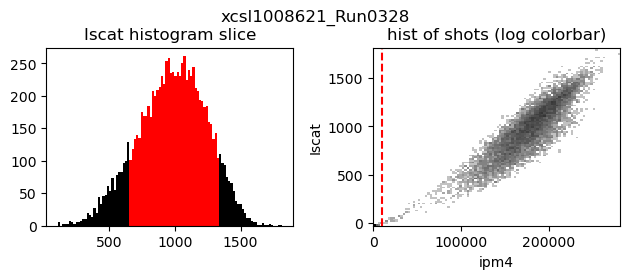

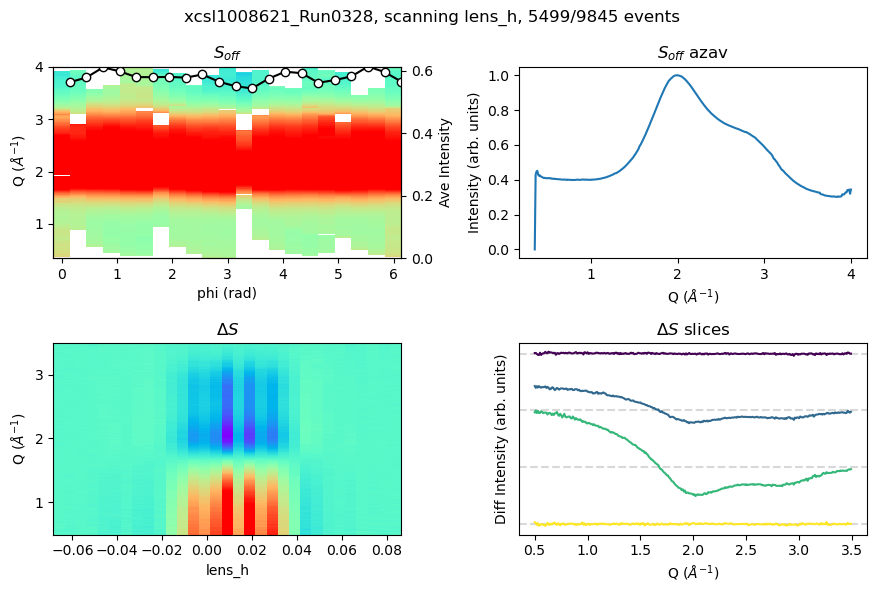

In [9]:
runs=[328]

ReduceData(smalldata_folder,exper,runs,outpath,paramDict,varDict)
    

# Load Data and Fit Gaussian

In [10]:
def gaus(x, a, b, c, d):
    return a * np.exp(-1*(x-b)**2/2/c**2) + d

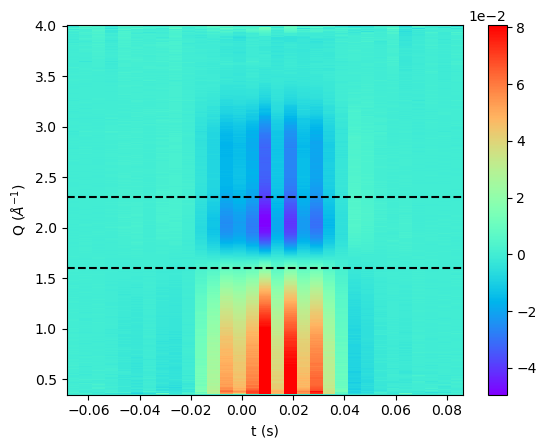

In [11]:
## load and plot 2D data
runnum=328
filepath=outpath+'/npy/'+exper+'_Run%04i_out.npy' %runnum

data= np.load(filepath,allow_pickle= True).item()

qs=data['qs']
phis=data['phis'][0:-1]
scanvar=data['xcenter']
diff=data['diff_bin']

#plot 2D
goodq,qrange=chooseR(1.6,2.3,qs)   
diff2d=np.nanmean(diff,1) #average over phis
plt.figure('scanvar2')
plot_2d(scanvar,qs,diff2d,fig='scanvar2')
plt.axhline(qrange[0],ls='--',color='k')
plt.axhline(qrange[1],ls='--',color='k')
# plt.clim(-5e-2,5e-2)

#take the sum of the absolute difference signal in q range to extract a 1D curve
diff1d=np.nansum(np.abs(diff2d[:,goodq]),1) 

Text(0.5, 0.98, "('run=', 328, 'center=', 0.012468333802471707, 'fwhm=', 0.03818976245112784, 'qrange', (1.6, 2.3))")

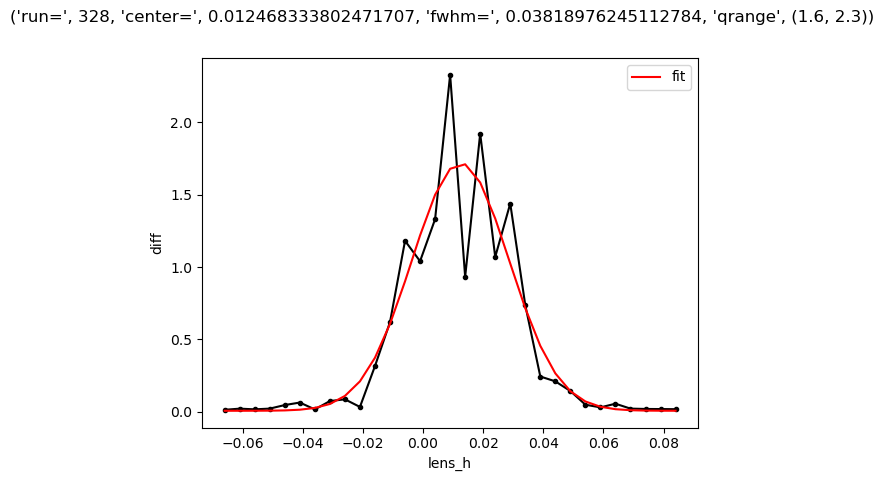

In [14]:
## fit 1D curve to gaussian

lens_v=True
lens_v=False

if lens_v:
    p0=[2,.05,.05,0.001] #lensv
    param, err =curve_fit(gaus,scanvar,diff1d,p0=p0)
    
else:
    p0=[2.,0.0,0.01,-0.001] #lensh
    param, err =curve_fit(gaus,scanvar,diff1d,p0=p0)

center=param[1]
fwhm=param[2]*2.355

plt.figure('fit')
plt.plot(scanvar,diff1d,'k.-')
plt.plot(scanvar,gaus(scanvar,*param),'r',label='fit')
if lens_v:
    plt.xlabel('lens_v')
else:
    plt.xlabel('lens_h')
plt.ylabel('diff')
plt.legend()
plt.suptitle(('run=',runnum,'center=',center,'fwhm=',fwhm,'qrange',qrange))